In [41]:
import numpy
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Input,Resizing,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10

import matplotlib.pyplot as plt

In [44]:
Efficient_net = EfficientNetB0(
    include_top = False,
    weights = 'imagenet',
    classes = 10,
    input_shape = (128,128,3)
)

In [4]:
Efficient_net.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [47]:
class Model:
  def __init__(self,Efficient_net):
    self.model = None
    Efficient_net.trainable = False
    # for layer in Efficient_net.layers:
    #   if not any(name in layer.name for name in ["block5","block6","block7","top","rescaling","stem","normalization"]):
    #     layer.trainable = False

  def build_model(self):
    model = Sequential()
    model.add(Input(shape=(32,32,3)))
    model.add(Resizing(128,128))
    model.add(Efficient_net)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(256,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(128,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(10,activation="softmax"))
    print(model.summary())
    self.model = model


  def compile_model(self):
    if self.model is None:
      raise ValueError("Error please build the model first using build_model function and Use compile_model to Compile model")
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
    self.model.compile(
        optimizer = optimizer,
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    print("Model Compilation successfully completed")
  def train_model(self,Augemented_images,X_test,Y_test,epochs):
    if self.model is None:
        raise ValueError("Error please build the model first using build_model function and Use compile_model to Compile model")

    earlystopping = EarlyStopping(
        monitor = "val_accuracy",
        patience = 5,
        restore_best_weights = True
    )

    history = self.model.fit(
        Augemented_images,
        epochs = epochs,
        validation_data = [X_test,Y_test],
        callbacks = [earlystopping]
    )

    return history

  def predictFunc(self,X_test):
    if self.model is None:
      raise ValueError("Error please build the model first using build_model function and Use compile_model to Compile model")
    preds = self.model.predict(X_test)
    return preds


In [57]:
class Evaluation:
  def __init__(self):
    pass
  @staticmethod
  def plot_model(hist):
    hist = hist.history
    plt.figure(figsize=(12,6))
    plt.plot(hist['accuracy'])
    plt.plot(hist['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","validation"])
    plt.show


In [32]:
  def normalize_images(images):
    return preprocess_input(images)

In [33]:
(X_train,Y_train),(X_test,Y_test) = cifar10.load_data()
X_train = normalize_images(X_train)
X_test = normalize_images(X_test)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)


In [35]:
Augment_data = ImageDataGenerator(
    rotation_range = 30,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [36]:
Augemented_images = Augment_data.flow(X_train,Y_train,batch_size=32)

In [48]:
model = Model(Efficient_net)
model.build_model()
model.compile_model()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_9 (Resizing)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,480,045 (17.09 MB)

 Trainable params: 429,194 (1.64 MB)

 Non-trainable params: 4,050,851 (15.45 MB)

None
Model Compilation successfully completed


In [49]:
Hist = model.train_model(Augemented_images,X_test,Y_test,10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 94s 44ms/step - accuracy: 0.6802 - loss: 0.9525 - val_accuracy: 0.8643 - val_loss: 0.3973
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7758 - loss: 0.6536 - val_accuracy: 0.8785 - val_loss: 0.3609
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7884 - loss: 0.6201 - val_accuracy: 0.8791 - val_loss: 0.3515
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.7984 - loss: 0.5853 - val_accuracy: 0.8875 - val_loss: 0.3366
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.8029 - loss: 0.5629 - val_accuracy: 0.8889 - val_loss: 0.3226
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.8113 - loss: 0.5491 - val_accuracy: 0.8841 - val_loss: 0.3329
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8169 - loss: 0.5305 - val_accuracy: 0.8906 - val_loss: 0.3233
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.8221 -

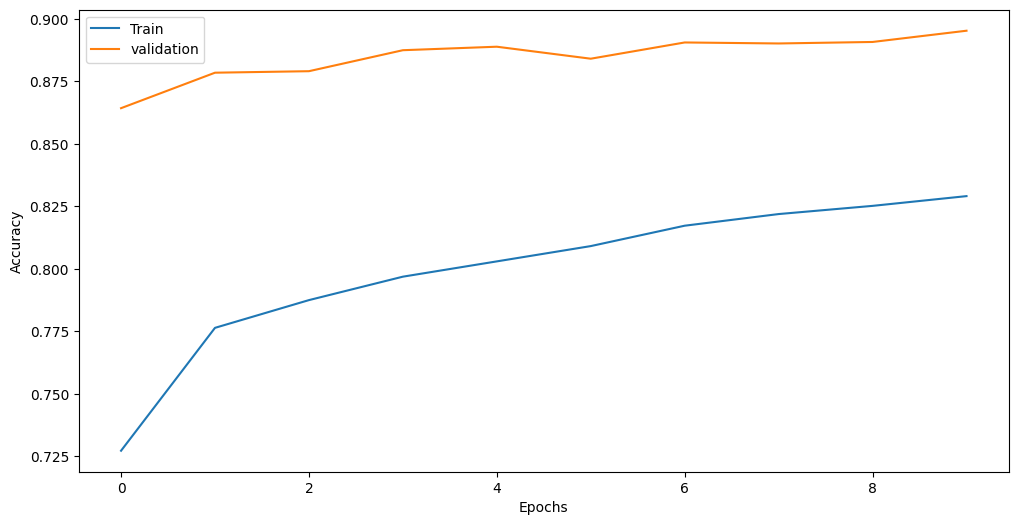

In [58]:
Evaluation.plot_model(Hist)